In [1]:
from bs4 import BeautifulSoup
import re

from urllib.request import urlopen
html = urlopen("https://en.wikipedia.org/wiki/Timeline_of_the_2020_coronavirus_pandemic_in_Iraq#cite_note-1").read()
# print(html)
cases = []
dates = []
Deaths = []
soup = BeautifulSoup(html)
chart = soup.find('div', attrs={'class': 'barbox tright'})
for elt in soup.find_all('tr'):
    if(len(elt)>=4):
        date,_,case,death = elt.find_all('td')
        cases.append(case.text.split('(')[0] if case.text else 0)
        # cases.append(case.text.split('(')[1] if case.text else 0)
        dates.append(date.text)
        Deaths.append(death.text.split('(')[0] if death.text else 0)
    

print(cases)

['Cases ', '1', '1', '8', '9', '9', '32', '32', '67', '71', '71', '79', '79', '110', '124', '133', '154', '164', '192', '208', '214', '233', '266', '316', '346', '382', '458', '506', '547', '630', '695', '728', '772', '820', '878', '961', '1,031', '1,122', '1,202', '1,232', '1,279', '1,318', '1,352', '1,378', '1,400', '1,415', '1,434', '1,482', '1,513', '1,539', '1,574', '1,602', '1,631']


In [2]:
import pandas as pd
from datetime import date
import datetime



# cleaning up data
for i in range(len(dates)):
    if('⋮' in dates[i]):
        start = datetime.datetime.strptime(dates[i-1], "%Y-%m-%d")
        start +=datetime.timedelta(days=1)
        end = datetime.datetime.strptime(dates[i+1], "%Y-%m-%d")
        date_array = \
        [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]
        
        dates.pop(i)
        d=Deaths.pop(i)
        c=cases.pop(i)
        
        new_counter = i
        for date_object in date_array:
            # print(date_object.strftime("%Y-%m-%d"))
            dates.insert(new_counter, date_object.strftime("%Y-%m-%d"))
            Deaths.insert(new_counter, d)
            cases.insert(new_counter, c)
            new_counter+=1
            
for i in range(len(dates)):
    if('⋮' in dates[i]):
        dates.pop(i)
        Deaths.pop(i)
        cases.pop(i)            
            
for i in range(1, len(cases)):
    if type(cases[i]) is str:
        cases[i]=int(cases[i].replace(',',''))
    elif type(cases[i]) is float:
        cases[i]=int(cases[i])
    if type(Deaths[i]) is str:
        Deaths[i]=int(Deaths[i].replace(',',''))
    elif type(Deaths[i]) is float:
        Deaths[i]=int(Deaths[i])
            
            
    
print(len(dates),len(Deaths),len(cases))
df = pd.DataFrame({'Cases': cases[1:], 'Dates': dates[1:], 'Deaths': Deaths[1:]})
# df = df.drop(df[df.Dates == '⋮'].index)
df.set_index('Dates', inplace=True)
df.head()

# print(cases, dates, precentages)

60 60 60


,Cases,Deaths
Dates,,
2020-02-24,1,0
2020-02-25,1,0
2020-02-26,1,0
2020-02-27,1,0
2020-02-28,1,0


In [3]:
start = datetime.datetime.strptime("2020-02-24", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-04-19", "%Y-%m-%d")
date_array = \
len([start + datetime.timedelta(days=x) for x in range(0, (end-start).days)])
print(date_array)

55


In [4]:
df.to_csv("formatted-data.csv")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002213C268208>],
      dtype=object)

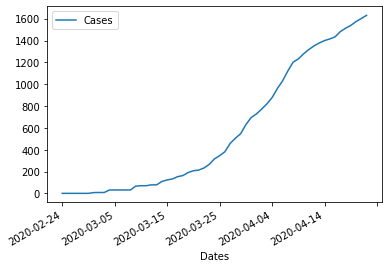

In [23]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


# to reproduce same results
tf.random.set_seed(1234)

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False


# filtering my dataset to only use cases row

data = df.filter(['Cases'])
data.plot(subplots=True)

In [24]:
import math
dataset = data.values
training_data_len = math.ceil( len(dataset) *.8) 

In [25]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()

Num GPUs Available:  1


True

In [56]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [27]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [28]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(5,len(train_data)):
    # for every 5 numbers going to x (input) 1 goes to y (expected output)
    x_train.append(train_data[i-5:i,0])
    y_train.append(train_data[i,0])
    

    
print(len(y_train))
print(len(x_train))

43
43


In [29]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
print(y_train.shape)
print(x_train.shape)

(43,)
(43, 5)


In [30]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# (40, 5) to (40, 5, 1)
x_train.shape

(43, 5, 1)

In [67]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))




#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
#Train the model
model.fit(x_train, y_train, batch_size=5, epochs=26)

Train on 43 samples
Epoch 1/26
43/43 [==============================] - 1s 33ms/sample - loss: 0.0011
Epoch 2/26
43/43 [==============================] - 0s 1ms/sample - loss: 5.9885e-04
Epoch 3/26
43/43 [==============================] - 0s 1ms/sample - loss: 3.1977e-04
Epoch 4/26
43/43 [==============================] - 0s 1ms/sample - loss: 7.3088e-04
Epoch 5/26
43/43 [==============================] - 0s 1ms/sample - loss: 8.4870e-04
Epoch 6/26
43/43 [==============================] - 0s 1ms/sample - loss: 5.9155e-04
Epoch 7/26
43/43 [==============================] - 0s 1ms/sample - loss: 6.8332e-04
Epoch 8/26
43/43 [==============================] - 0s 1ms/sample - loss: 8.7146e-04
Epoch 9/26
43/43 [==============================] - 0s 1ms/sample - loss: 5.1189e-04
Epoch 10/26
43/43 [==============================] - 0s 1ms/sample - loss: 3.8420e-04
Epoch 11/26
43/43 [==============================] - 0s 1ms/sample - loss: 2.7464e-04
Epoch 12/26
43/43 [===========================

In [85]:
#Test data set
#basicaly the same thing i did with the train data set
test_data = scaled_data[training_data_len - 5: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(5,len(test_data)):
    x_test.append(test_data[i-5:i,0])

In [86]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test.shape

(11, 5, 1)

In [87]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [88]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

41.14933897583815

c:\users\omar\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


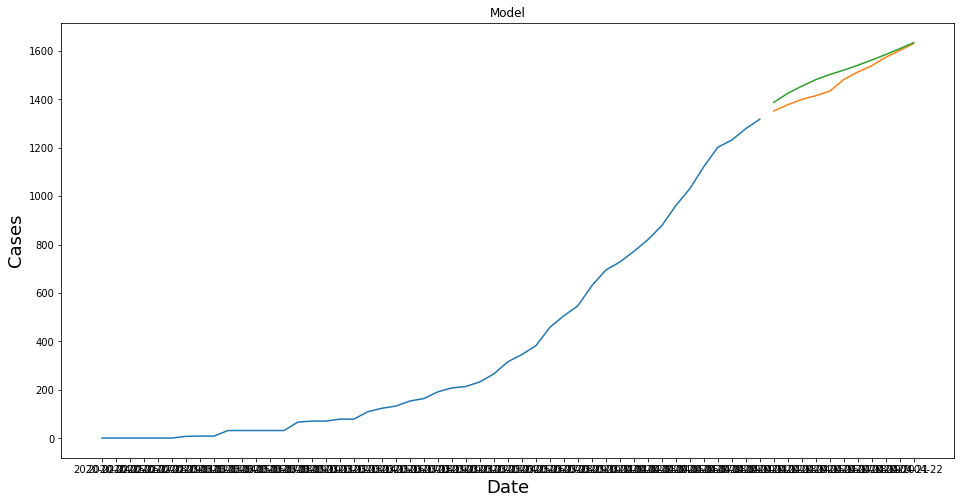

In [89]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Cases', fontsize=18)
plt.plot(train['Cases'])
plt.plot(valid[['Cases', 'Predictions']])
plt.show()

In [90]:
valid.head

<bound method NDFrame.head of             Cases  Predictions
Dates                         
2020-04-12   1352  1387.574829
2020-04-13   1378  1425.093628
2020-04-14   1400  1454.600952
2020-04-15   1415  1481.422852
2020-04-16   1434  1502.818359
2020-04-17   1482  1520.707153
2020-04-18   1513  1540.744263
2020-04-19   1539  1562.555664
2020-04-20   1574  1585.092407
2020-04-21   1602  1609.540405
2020-04-22   1631  1634.254028>

In [91]:
# actual predictions

#Convert x_test to a numpy array 
x_test2 = np.array(data[:5])

#Reshape the data into the shape accepted by the LSTM
x_test2 = np.reshape(x_test2, (1,x_test2.shape[0],1))
x_test2.shape

(1, 5, 1)

In [92]:
#Getting the models predicted price values
prediction = model.predict(x_test2) 
prediction = scaler.inverse_transform(prediction)#Undo scaling
int(prediction[0][0])

1696